In [1]:
!pip install pennylane scikit-learn matplotlib seaborn torch --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 4 features for QML circuits (you can use PCA if needed)
X_small = X_scaled[:, :4]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_small, y, test_size=0.2, random_state=42)

print(f"X shape: {X_train.shape}, Y shape: {y_train.shape}")


X shape: (455, 4), Y shape: (455,)


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Classical SVM Accuracy: {acc_svm:.4f}")


Classical SVM Accuracy: 0.9211


In [6]:
import pennylane as qml

dev = qml.device("default.qubit", wires=4)

def kernel_circuit(x1, x2):
    @qml.qnode(dev)
    def circuit():
        qml.templates.AngleEmbedding(x1, wires=range(4))
        qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(4))
        return qml.probs(wires=range(4))
    return circuit()[0]

def quantum_kernel_matrix(X1, X2):
    n, m = len(X1), len(X2)
    mat = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            mat[i, j] = kernel_circuit(X1[i], X2[j])
    return mat

# Use small sample for performance reasons
X_train_q = X_train[:50]
y_train_q = y_train[:50]
X_test_q = X_test[:10]
y_test_q = y_test[:10]

K_train = quantum_kernel_matrix(X_train_q, X_train_q)
K_test = quantum_kernel_matrix(X_test_q, X_train_q)

qsvm = SVC(kernel='precomputed')
qsvm.fit(K_train, y_train_q)
y_pred_qsvm = qsvm.predict(K_test)

acc_qsvm = accuracy_score(y_test_q, y_pred_qsvm)
print(f"Quantum Kernel SVM Accuracy: {acc_qsvm:.4f}")


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Quantum Kernel SVM Accuracy: 1.0000


In [11]:
import pennylane as qml
from pennylane.qnn import TorchLayer
import torch
import torch.nn as nn
import torch.optim as optim

n_qubits = 4
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev, interface="torch")
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
# Define shapes of trainable weights
weight_shapes = {"weights": (n_layers, n_qubits, 3)}


qlayer = TorchLayer(circuit, weight_shapes)


In [12]:
class QNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = qlayer
        self.linear = nn.Linear(n_qubits, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.q_layer(x)
        x = self.linear(x)
        return self.sigmoid(x)


In [13]:
import torch
from sklearn.model_selection import train_test_split

# Assuming X_train and y_train are already from the breast cancer dataset (with 4 features)
X_sample = torch.tensor(X_train[:100], dtype=torch.float32)
y_sample = torch.tensor(y_train[:100], dtype=torch.float32).view(-1, 1)

X_test_qnn = torch.tensor(X_test[:30], dtype=torch.float32)
y_test_qnn = y_test[:30]


In [33]:
model = QNet()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    output = model(X_sample)
    loss = loss_fn(output, y_sample)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")


Epoch 1 - Loss: 0.7041
Epoch 2 - Loss: 0.6994
Epoch 3 - Loss: 0.6948
Epoch 4 - Loss: 0.6905
Epoch 5 - Loss: 0.6864
Epoch 6 - Loss: 0.6825
Epoch 7 - Loss: 0.6788
Epoch 8 - Loss: 0.6752
Epoch 9 - Loss: 0.6719
Epoch 10 - Loss: 0.6686


QNN Accuracy: 0.6000


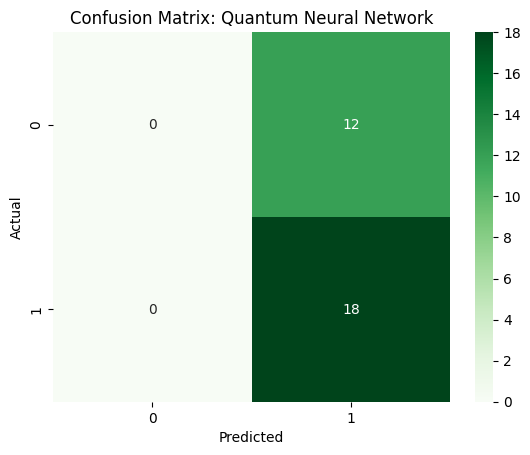

In [34]:
model.eval()
with torch.no_grad():
    y_pred_qnn = model(X_test_qnn).numpy()
    y_pred_qnn = (y_pred_qnn > 0.5).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

acc_qnn = accuracy_score(y_test_qnn, y_pred_qnn)
cm_qnn = confusion_matrix(y_test_qnn, y_pred_qnn)

print(f"QNN Accuracy: {acc_qnn:.4f}")

sns.heatmap(cm_qnn, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: Quantum Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
